    1)Clustering de datos.

Para el set de datos dado, se analizaran diferentes técnicas de clustering, entre ellas K-means, Mezcla de Gaussianas y DBSCAN. 

**Importar funciones**

In [1]:
from K_means import *
from dataset import *
from GMM import *
from DBSCAN import *

**Importar set de datos normalizado**

In [2]:
data = get_data('clustering.csv')

    K-means


K-means es un algoritmo de clasificación no supervisada (clusterización) que agrupa objetos en $k$ grupos basándose en sus características. El agrupamiento se realiza minimizando la suma de las distancias entre cada objeto y el centroide de su grupo o cluster. En este caso, se utiliza la distancia cuadrática.

El algoritmo consta de tres pasos:

1. **Inicialización**: Una vez escogido el número de grupos, $ k$, se establecen $ k$ centroides en el espacio de los datos, por ejemplo, seleccionándolos aleatoriamente.
2. **Asignación de objetos a los centroides**: Cada objeto de los datos se asigna a su centroide más cercano.
3. **Actualización de centroides**: Se actualiza la posición del centroide de cada grupo, tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a dicho grupo.


Estos pasos se repiten hasta que los centroides dejan de moverse o se mueven por debajo de una distancia umbral en cada iteración.

Los objetos se representan con vectores reales de $d$ dimensiones $(x_1, x_2, \ldots, x_n)$ y el algoritmo K-means construye $k$ grupos donde se minimiza la suma de las distancias de los objetos, dentro de cada grupo $S = \{S_1, S_2, \ldots, S_k\}$, a su centroide. El problema se puede formular de la siguiente manera:

\begin{equation*}
\min_{\mu_i} SE(\mu_i) = \min_S \sum_{i=1}^{k} \sum_{x_j \in S_i} \| x_j - \mu_i \|^2
\end{equation*}

donde $S$ es el conjunto de datos cuyos elementos son los objetos $x_j$, representados por vectores donde cada componente representa una característica o atributo. Tendremos $k$ grupos o clusters con su correspondiente centroide $\mu_i$. 

Las principales ventajas del método K-means son que es un método sencillo y rápido. Sin embargo, es necesario decidir el valor de $k$, y el resultado final depende de la inicialización de los centroides. Además, no converge al mínimo global sino a un mínimo local.



In [3]:
tolerance = 0.001
max_iter = 20
inertia_values = []
K_values = range(2,20)
models_kmeans= {}


In [4]:

for k in K_values:
    model = K_means(k, tolerance, max_iter)
    clusters, centroids = model.set_clusters(data)
    inertia = model.inertia(data)
    models_kmeans[k] = {'clusters': clusters, 'centroids': centroids, 'inertia': inertia}
    inertia_values.append(inertia)


**Cálculo de la inercia**

Para evaluar el rendimiento del clustering de los distintos modelos, cada uno con una cantidad distinta de clusters, evaluaremos la inercia mediante el método de "ganancias decrecientes". Este método consiste en calcular la suma de las distancias al cuadrado de todos los puntos de un cluster respecto a su centroide. Esta métrica nos indica cuánta distancia o diferencia hay entre los puntos clasificados en el mismo cluster.

La inercia ($I$) se calcula utilizando la siguiente ecuación:

\begin{equation}
I = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
\end{equation}



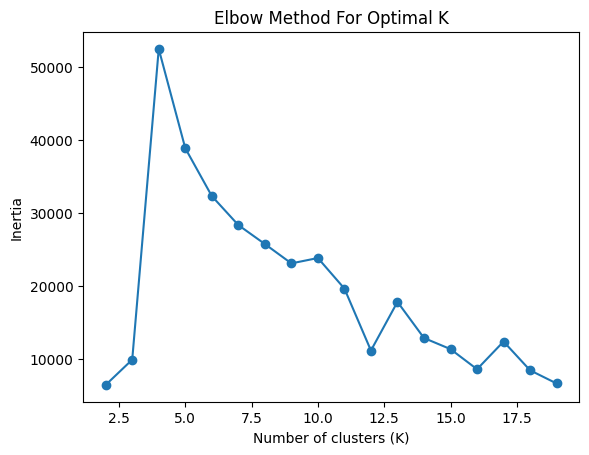

In [5]:

Kmeans_inertia(K_values, inertia_values)


Se observa que, al inicio, la inercia es muy baja, pero esos datos no son útiles porque sabemos que nuestro conjunto de datos cuenta con una mayor cantidad de clusters. Luego, mediante el método del codo, podríamos inferir que una cantidad de clusters entre 12 y 15 parece ser suficiente.

Sería recomendable probar el rendimiento del modelo con una mayor cantidad de clusters para observar mejor los cambios, pero debido al costo computacional y a que la curva comienza a aplanarse, solo se prueban hasta 20 clusters.


**Modelos con distintas cantidades de clusters**



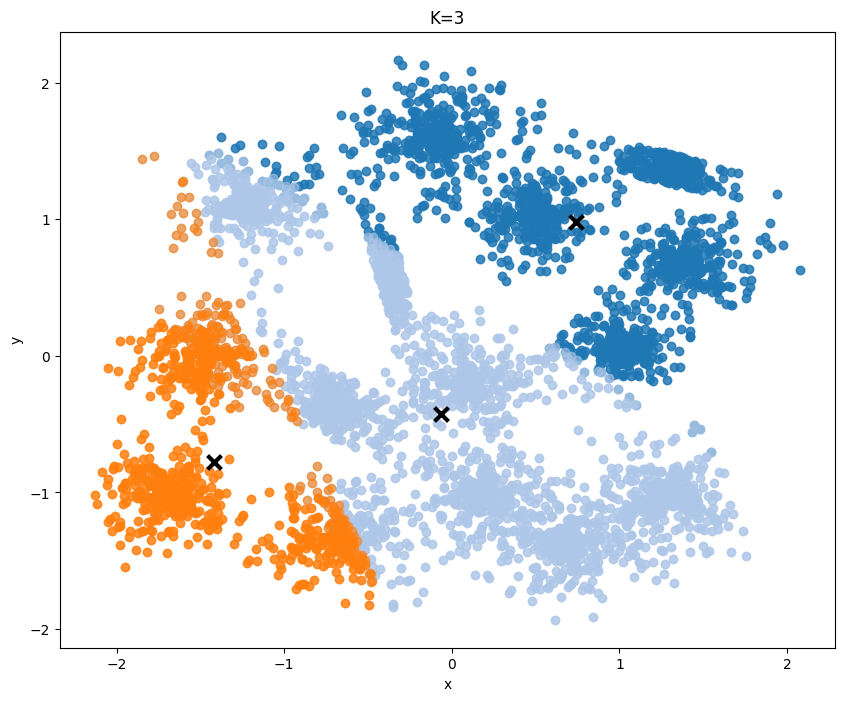

In [6]:

Kmeans_plot_clusters(models_kmeans[3],3)


Se observa que tres clusters no es la cantidad apropiada, ya que las nubes de puntos entre el mismo cluster, están muy dispersas.

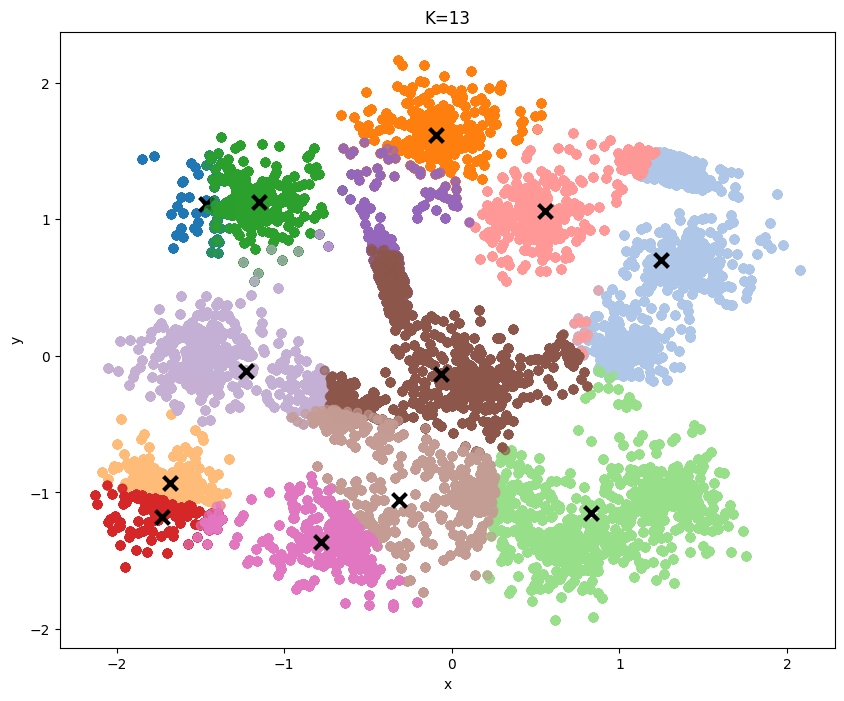

In [7]:

Kmeans_plot_clusters(models_kmeans[13],13)


Una cantidad promedio de lo que podría apreciarse en el gráfico de las inercias como "el codo" parece clusterizar de manera más apropiada las nubes de puntos con formas geométricas más circulares. Sin embargo, no tiene facilidad para capturar los clusters más "estirados", por lo que termina agrupándolos con otras nubes de puntos más reconocibles.


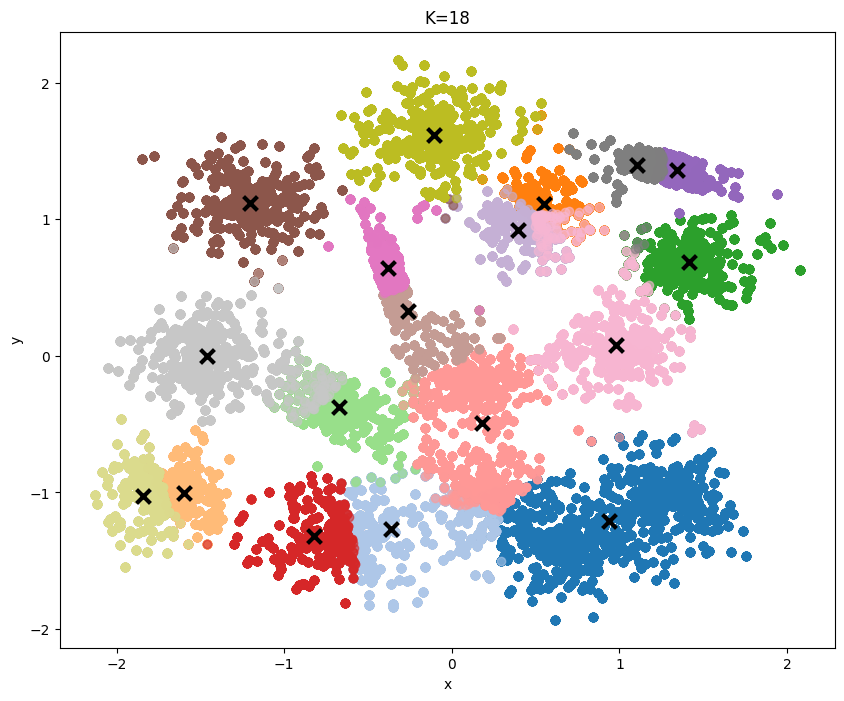

In [24]:

Kmeans_plot_clusters(models_kmeans[18],18)

Por último, con una gran cantidad de clusters, aunque la inercia es menor, se observa que se crean muchos subgrupos entre clusters de manera innecesaria. Por ello, hay centroides que se encuentran muy cercanos, lo que indica que deberían pertenecer a un solo cluster.


    GAUSSIAN MIXTURE MODEL 

Supongamos que hay $K$ clusters (para simplificar, aquí se asume que el número de clusters es conocido y es $K$). Por lo tanto, $\mu$ y $\Sigma$ también se estiman para cada $k$. Si hubiera solo una distribución, se estimarían mediante el método de máxima verosimilitud. Pero dado que hay $K$ clusters y la densidad de probabilidad se define como una función lineal de las densidades de todas estas $K$ distribuciones, es decir,

\begin{equation*}
p(X) = \sum_{k=1}^K \pi_k G(X|\mu_k, \Sigma_k)
\end{equation*}

donde $\pi_k$ es el coeficiente de mezcla para la $k$-ésima distribución. Para estimar los parámetros mediante el método de máxima verosimilitud, se calcula $p(X|\mu, \Sigma, \pi)$.

\begin{equation*}
\ln{p( X|\mu, \Sigma, \pi)} = \sum_{i=1}^N \ln \left( \sum_{k=1}^K \pi_k G(X_i | \mu_k, \Sigma_k) \right)
\end{equation*}

Ahora definamos una variable aleatoria $\gamma_k(X)$ tal que $\gamma_k(X) = p(k|X)$.

A partir del teorema de Bayes,


\begin{equation*}
\gamma_k(X) = \frac{p(X|k)p(k)}{\sum_{k=1}^K p(k)p(X|k)} = \frac{p(X|k)\pi_k}{\sum_{k=1}^K \pi_k p(X|k)}
\end{equation*}


Ahora, para que la función de verosimilitud logarítmica sea máxima, su derivada de $p(X|\mu, \Sigma, \pi)$ con respecto a $\mu$, $\Sigma$ y $\pi$ debe ser cero. Así que, igualando a cero la derivada de $p(X|\mu, \Sigma, \pi)$ con respecto a $\mu$ y reordenando los términos, obtenemos:


\begin{equation*}
\mu_k = \frac{\sum_{n=1}^N \gamma_k(x_n)x_n}{\sum_{n=1}^N \gamma_k(x_n)}
\end{equation*}

De manera similar, tomando la derivada con respecto a $\Sigma$ y $\pi$ respectivamente, se pueden obtener las siguientes expresiones:


\begin{equation*}
\Sigma_k = \frac{\sum_{n=1}^N \gamma_k(x_n)(x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^N \gamma_k(x_n)}
\end{equation*}

Y


\begin{equation*}
\pi_k = \frac{1}{N} \sum_{n=1}^N \gamma_k(x_n)
\end{equation*}

In [9]:

models_gmm = {}
inertias = {}
for k in K_values:
    model = GMM(k, 50)
    log_likelihoods = model.Train(data,max_iter,0.001)
    clusters = model.set_clusters(data)
    mu = [np.mean(cluster, axis=0) for cluster in clusters.values()]
    sigma = [np.cov(np.array(cluster).T) for cluster in clusters.values()]
    models_gmm[k] = [clusters, mu, sigma]
    inertias[k]= calculate_inertia(clusters)



**Cálculo de la inercia**

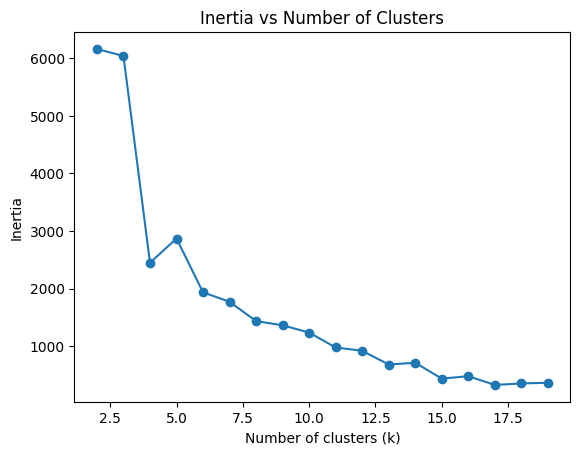

In [10]:
GMM_inertia(inertias)


Al graficar las inercias con respecto a la cantidad de clusters, se observa que, con una menor cantidad de clusters, aquellos previamente clasificados como óptimos en k-means parecen ser adecuados, situándose el codo entre 7 y 12 clusters. Sin embargo, al visualizar los clusters, se observa que son necesarios al menos entre 13 y 15 clusters para lograr una buena separación.

Una consideración adicional podría ser la necesidad de un mayor número de iteraciones, tanto en el k-means utilizado para inicializar los parámetros del modelo, como en las iteraciones empleadas para alcanzar la convergencia. Esto podría resultar en mejores valores de inercia.


**Modelos con distintas cantidades de clusters**

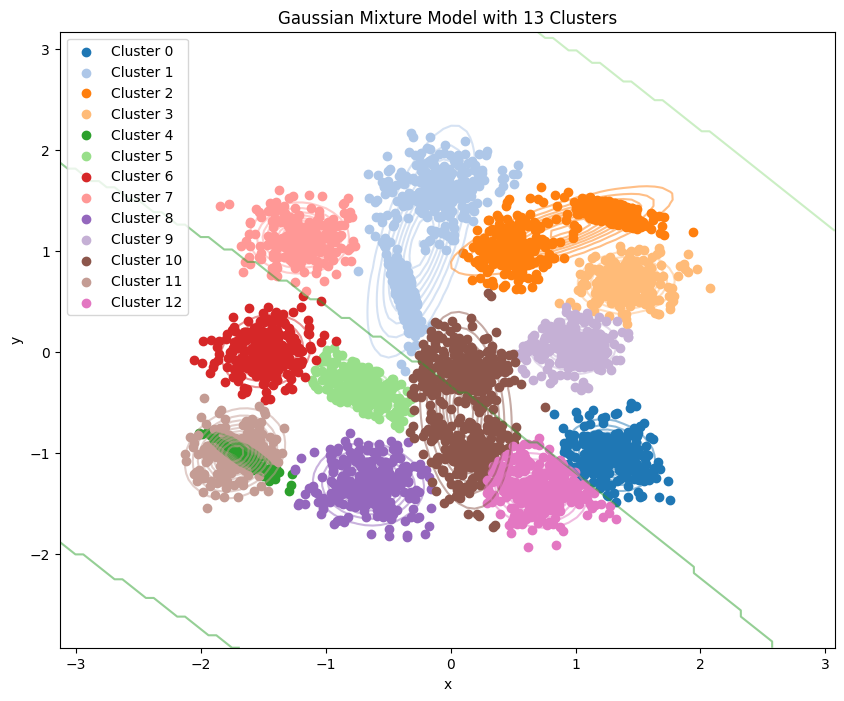

In [22]:
plot_models(models_gmm[13], data, 13)


Se observa una buena separación entre los clusters; sin embargo, algunos de ellos comparten centroides con otros clusters. Es posible que, con un mayor número de iteraciones, los clusters se hubieran ajustado de manera más precisa. No obstante, incluso con esta cantidad de clusters, el modelo aún no logra diferenciar adecuadamente aquellos clusters más "alargados".


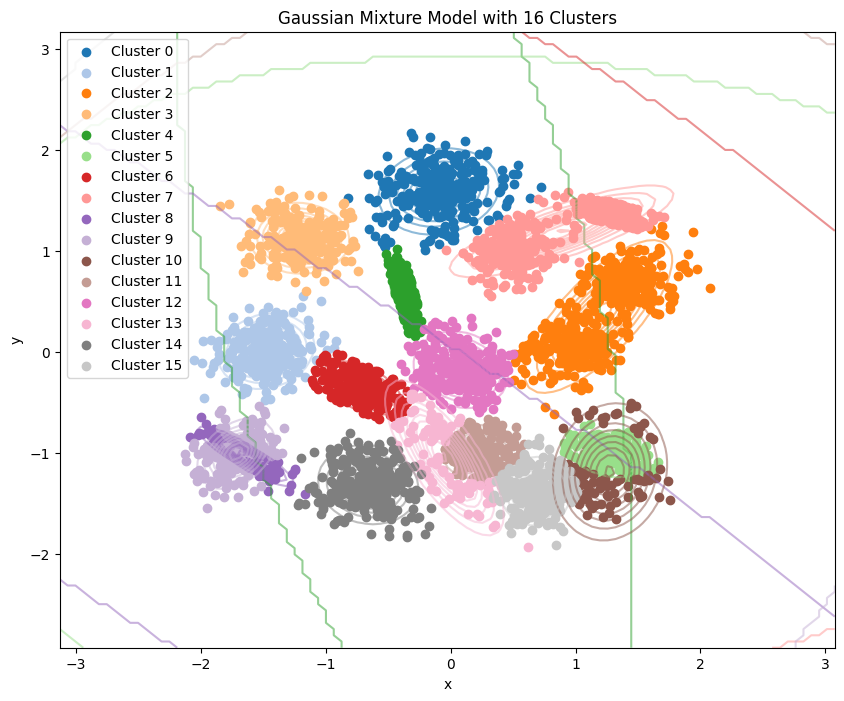

In [23]:

plot_models(models_gmm[15], data, 15)



Aunque continúan existiendo clusters que comparten centroides entre sí, se observa una mejora en la capacidad del modelo para detectar clusters con formas alargadas y una separación más precisa de aquellos clusters con formas redondeadas.


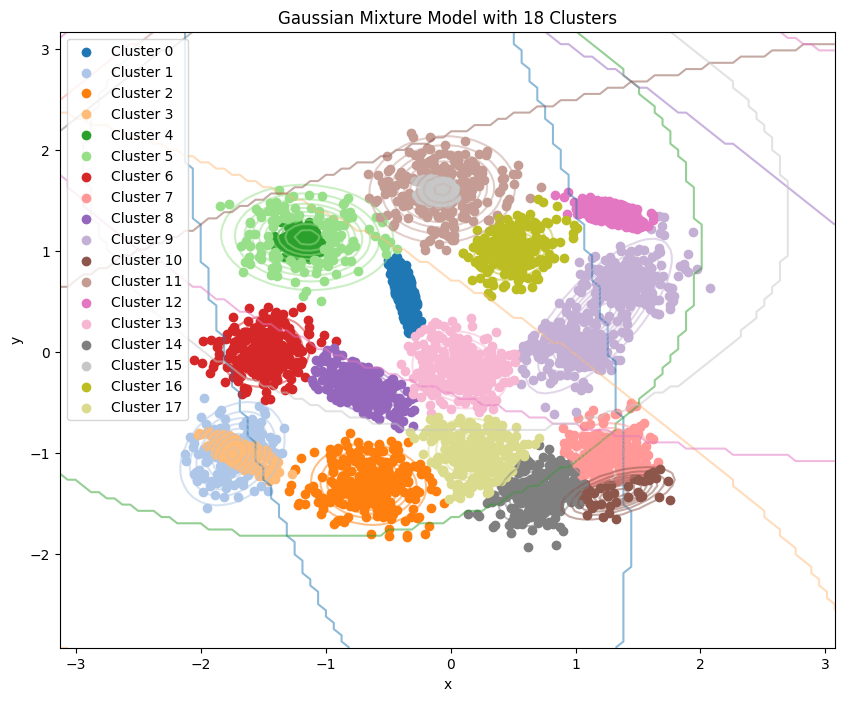

In [21]:

plot_models(models_gmm[18], data, 18)

Por último, se observa que la elección de 18 clusters resulta excesiva. Aunque con un mayor número de iteraciones los clusters podrían converger hacia centroides mejor posicionados, se evidencia la formación de clusters que contienen muy pocos puntos, los cuales no justifican la creación de un nuevo cluster.


    DBSCAN 
    

 El algoritmo DBSCAN se basa en esta noción intuitiva de "clusters" y "ruido". La idea principal es que para cada punto de un cluster, el vecindario de un radio dado debe contener al menos un número mínimo de puntos.

**Inicialización:Parámetros requeridos para el algoritmo DBSCAN**


**→ eps**: Define el vecindario alrededor de un punto de datos, es decir, si la distancia entre dos puntos es menor o igual a 'eps', entonces se consideran vecinos. Si el valor de eps se elige demasiado pequeño, una gran parte de los datos se considerará como un outlier. Si se elige demasiado grande, los clusters se fusionarán y la mayoría de los puntos de datos estarán en los mismos clusters. 

**→ k**: Número mínimo de vecinos (puntos de datos) dentro del radio eps. Cuanto mayor sea el conjunto de datos, mayor deberá ser el valor de k.

En este algoritmo, tenemos 3 tipos de puntos de datos:

**Punto central**: Un punto es un punto central si tiene más de k puntos dentro de eps.

**Punto frontera**: Un punto que tiene menos de k dentro de eps pero está en el vecindario de un punto central.

**Ruido o outlier**: Un punto que no es un punto central ni un punto frontera.

**Pasos utilizados en el algoritmo DBSCAN**

**1.** Encontrar todos los puntos vecinos dentro de eps e identificar los puntos centrales o visitados con más de k vecinos.

**2.** Para cada punto central, si no está ya asignado a un cluster, crear un nuevo cluster.

**3.** Encontrar recursivamente todos sus puntos conectados por densidad y asignarlos al mismo cluster que el punto central. 

Dos puntos $a$ y $b$ se dicen conectados por densidad si existe un punto $c$ que tiene un número suficiente de puntos en su vecindario y ambos puntos $a$ y $b$ están dentro de la distancia eps. Este es un proceso de encadenamiento. 

In [3]:
eps_values = [0.01,0.05,0.07,0.9,0.1]
K_values = [4,8,12,15]
inertias = {}
models = []


In [4]:

for eps in eps_values:
    for K in K_values:
        dbscan = DBSCAN(eps=eps, K=K)
        clusters = dbscan.fit_predict(data)
        models.append((eps, K, clusters))
        inertias[(eps, K)] = calculate_inertia(clusters)

**Análisis de Inercia para distintos valores de epsilon y k**


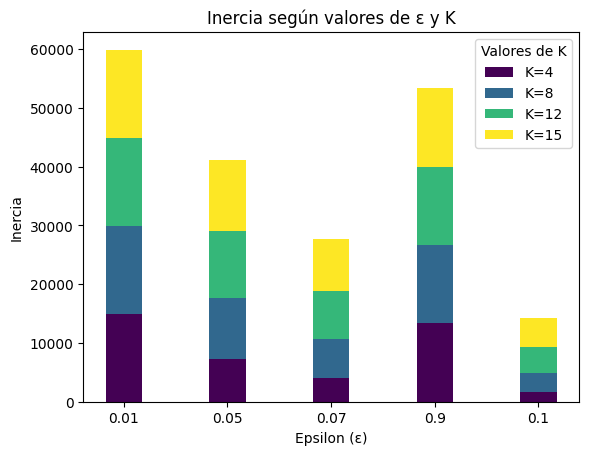

In [5]:

data = []
for eps in eps_values:
    row = [inertias.get((eps, K), 0) for K in K_values]
    data.append(row)

inertia_df = pd.DataFrame(data, index=eps_values, columns=K_values)
fig, ax = plt.subplots()
bar_width = 0.35
x_positions = np.arange(len(eps_values))
colors = plt.cm.viridis(np.linspace(0, 1, len(K_values)))


bottom = np.zeros(len(eps_values))
for idx, K in enumerate(K_values):
    ax.bar(x_positions, inertia_df[K], bar_width, bottom=bottom, label=f'K={K}', color=colors[idx])
    bottom += inertia_df[K]


ax.set_xlabel('Epsilon (ε)')
ax.set_ylabel('Inercia')
ax.set_title('Inercia según valores de ε y K')
ax.set_xticks(x_positions)
ax.set_xticklabels(eps_values)
ax.legend(title='Valores de K')

plt.show()

Por una parte, se observa que no resulta útil analizar los valores de inercia para las distintas combinaciones de epsilon y k en el modelo DBSCAN. Aunque algunos valores podrían parecer menores, los gráficos resultantes no muestran una adecuada división de los datos en clusters.

Por otra parte, se observa que a medida que aumenta la cantidad de vecinos considerados dentro del radio dado, la inercia también aumenta significativamente. Este fenómeno podría explicarse por una mayor división en clusters, lo que conlleva a una mayor cantidad de puntos clasificados como ruido, dispersos entre sí. Estos puntos, al tener una distancia considerable respecto a un centroide relativo, distorsionan la noción de los clusters reales.


**Modelos con distintos valores de epsilon y k**

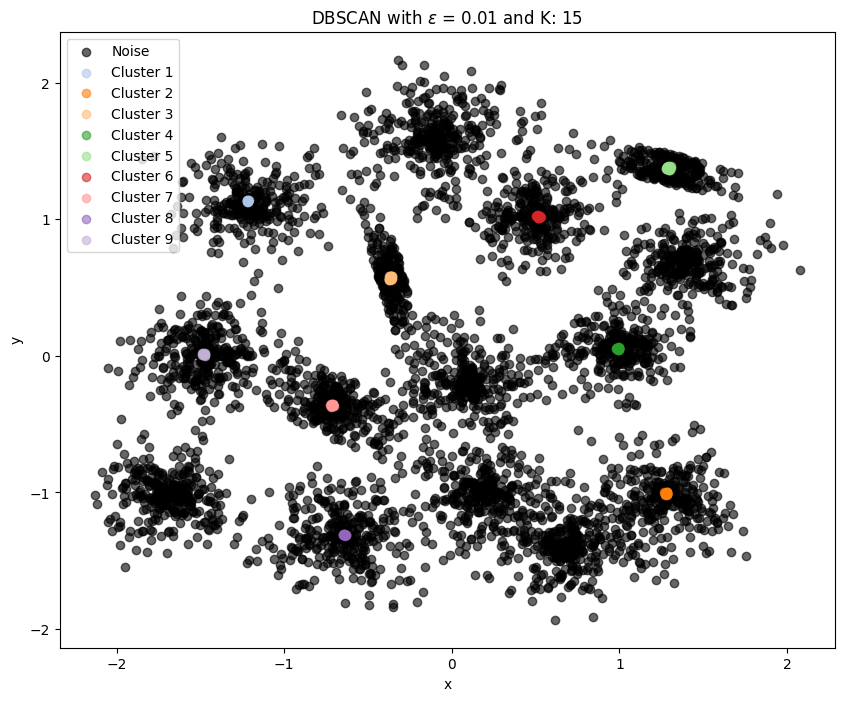

In [15]:
eps, K, clusters = models[3]
plot_clusters(clusters,eps,K)

Con un valor muy pequeño de epsilon y un alto número de vecinos, se observa que los clusters resultan muy reducidos. En otras palabras, las restricciones son tan estrictas que el modelo no puede expandirse sobre las nubes de puntos, ni siquiera identificar aquellos clusters que presentan densidades poco definidas.


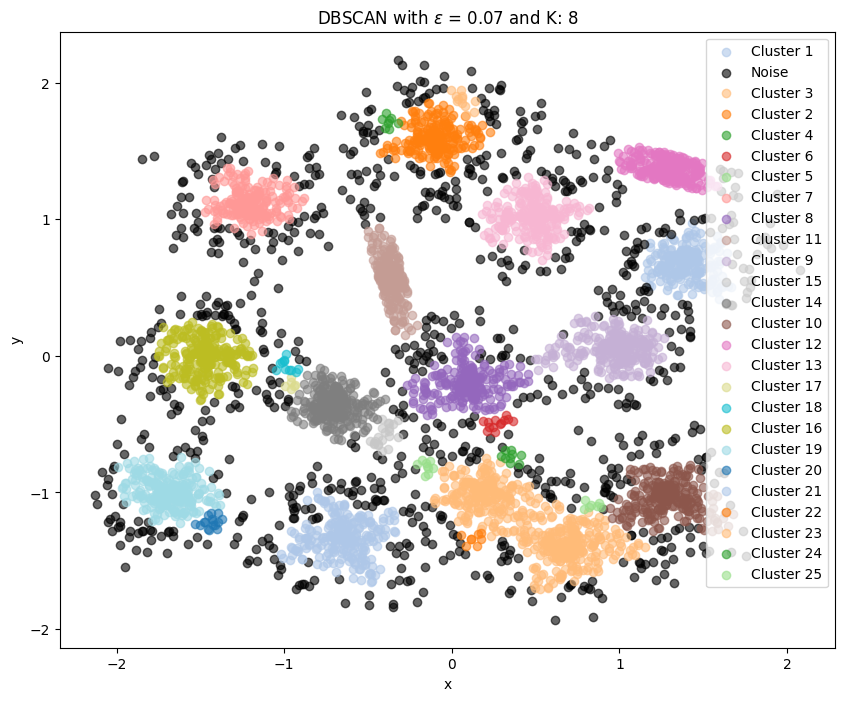

In [16]:
eps, K, clusters = models[9]
plot_clusters(clusters,eps,K)


Por otra parte, con un valor mayor de epsilon pero una baja cantidad de vecinos, se logra identificar las nubes de puntos más densas. Sin embargo, debido a que las restricciones no son lo suficientemente estrictas, se generan clusters con muy pocos puntos, lo cual no es deseable, ya que la cantidad final de clusters queda sesgada por un número de clusters que no aportan información real.

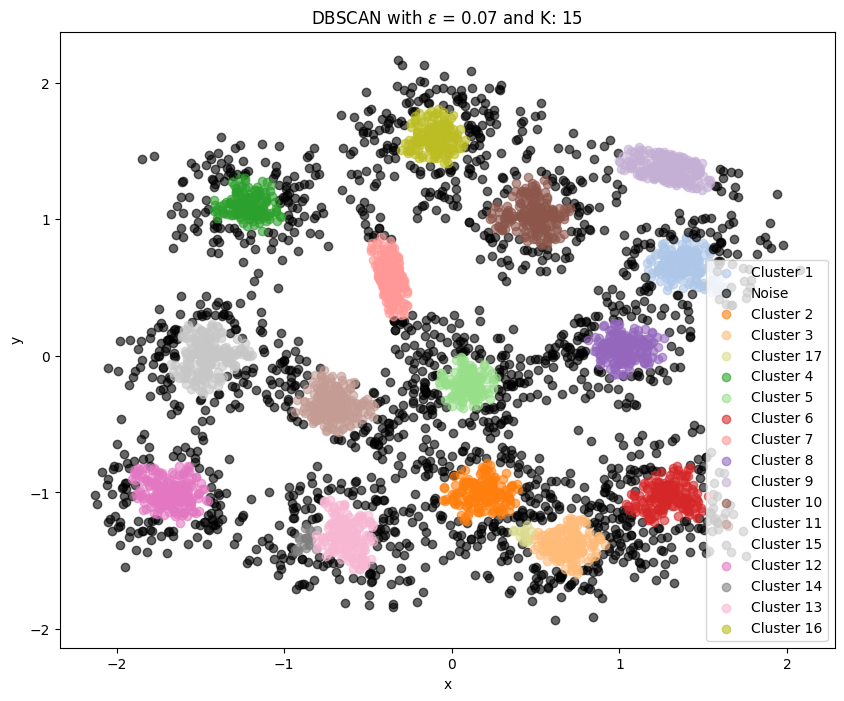

In [17]:
eps, K, clusters = models[11]
plot_clusters(clusters,eps,K)

Con el mismo valor de epsilon que en el caso anterior, pero con una mayor cantidad de vecinos, se observa que se resuelve el problema de la cantidad de clusters con pocos puntos. No obstante, esto conlleva a una mayor clasificación de puntos como ruido, lo cual podría representar un inconveniente, dado que se considera a muchos puntos como no relevantes, lo que implica una concentración excesiva de información.

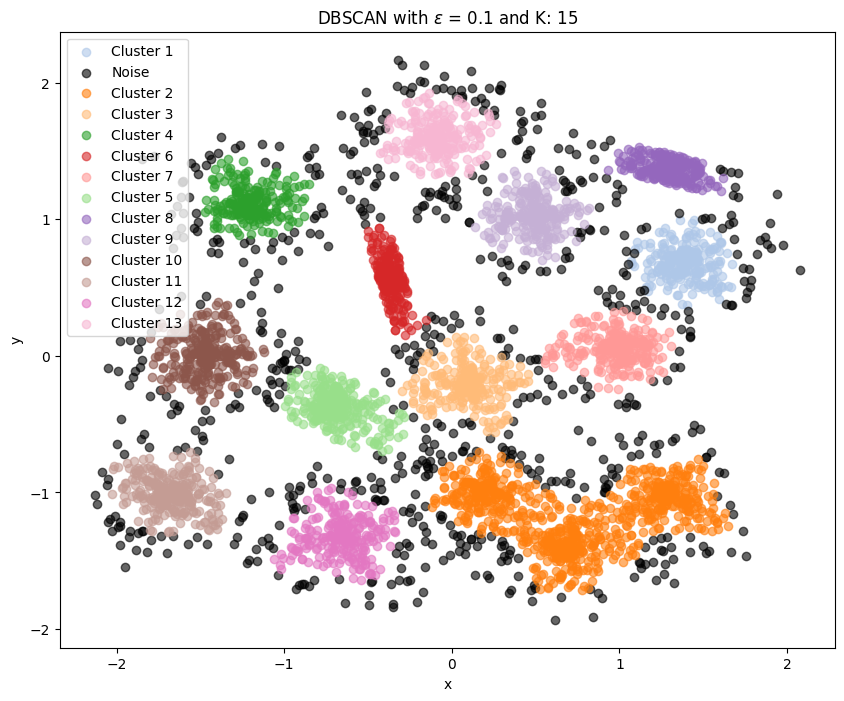

In [18]:
eps, K, clusters = models[19]
plot_clusters(clusters,eps,K)


Finalmente, el caso ideal pareciera ser un valor de epsilon relativamente amplio y una restricción de vecinos también considerable. Esta configuración parece proporcionar una mayor flexibilidad para expandir la forma del cluster, sin embargo, mantiene la capacidad de preservar la noción de densidad. Además, se observa una disminución en la cantidad de puntos considerados como ruido.